In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wordcloud-fa
!pip install gensim

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import plot_confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten

import re
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.5.0


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MasterThesis/DataSet-forUsing/7-offDSA2020-dev-train-test-10000.xlsx')
# df.head()
# df.describe

In [ ]:
df.columns = ['tweets', 'off','hs','new_label']
# df.head()

In [ ]:
df = df.drop(['hs','new_label'], axis=1)

Text(0.5, 1.0, 'Hate speech Data Distribution')

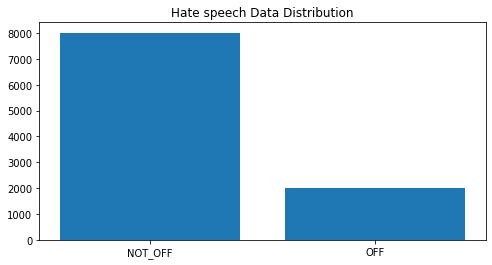

In [ ]:
val_count = df.off.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Hate speech Data Distribution")

In [ ]:
import random
random_idx_list = [random.randint(1,len(df.tweets)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,tweets,off
165,RT @USER: يا يوم يا خفيف يا لطيف,NOT_OFF
181,يا مكثرك فيني يا جعلك ما تقل..,NOT_OFF
7105,@USER يا عُمري يا عُمري يا نُورة ، مبسوطة جدًا...,NOT_OFF
6598,"اللهم يا ذا الرحمة الواسعة, يا مُطلعاً على الس...",NOT_OFF
147,RT @USER: @USER يا انته يا احلا مافي الكون • و...,NOT_OFF
6335,اللقم بس يا حفاظة يا صغير السعودية URL,OFF
2683,أرجوك يا حُباً يا حُلماً ، كُن.,NOT_OFF
4506,ميسي يا قليل الادب يا سافل يا واطي,OFF
5959,@USER يا ليته كذا يا ابو ديما .. يحسبونها مخدر...,NOT_OFF
7200,@USER قلنا لك يا استاذ سعد اسعدنا الله يسعدك د...,NOT_OFF


#Text Preprocessing¶


In [ ]:
import gensim

In [ ]:
# load the model
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/Word Embedding/Twt-CBOW/Twt-CBOW')

In [ ]:
text_cleaning_re = "[a-zA-Z]|\d+|[٠١٢٣٤٥٦٧٨٩]|[.#،<>@,\\-_”“٪ًَ]"
def preprocess(text):
  # search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!','#']
  # replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ',' ']
  #remove tashkeel
  p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(p_tashkeel,"", str(text))
  # text = text.replace('وو', 'و')
  # text = text.replace('يي', 'ي')
  # text = text.replace('اا', 'ا')
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  #remove longation
  text = re.sub(r'(.)\1+', r'\1\1', str(text)) 
  text = re.sub("[إأآا]", "ا", str(text))
  text = re.sub("ى", "ي", str(text))
  # text = re.sub("ؤ", "ء", text)
  # text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", str(text))
  # for i in range(0, len(search)):
  #       text = text.replace(search[i], replace[i])
  
   #trim    
  # text = text.strip()

  tokens = []
  for token in text.split():
    # if token not in stop_words:
      tokens.append(token)
  return " ".join(tokens)

In [ ]:
# preprocess('مشكوووور hello 156562سٌلمُ@#')
preprocess('_ salam # @  حمقى 12 ممتازة ياااااااارب ؟ ! سٌلمُ')

'حمقي ممتازه ياارب ؟ ! سلم'

In [ ]:
word = preprocess(u'حقير')

# find and print the most similar terms to a word
most_similar = model.wv.most_similar( word )
for term, score in most_similar:
	print(term, score)

سافل 0.6879982352256775
خسيس 0.6644033193588257
قذر 0.6214959621429443
منحط 0.6129060983657837
وقح 0.6018147468566895
غبي 0.5982157588005066
وحقير 0.5942843556404114
وسافل 0.5851724743843079
ومنحط 0.5787683725357056
جبان 0.5700664520263672


In [ ]:
word_vector = model.wv[ word ]
# word_vector

In [ ]:
df.tweets = df.tweets.apply(lambda x: preprocess(x))
df.tweets[:10]

0    في حاجات مينفعش نلفت نظركوا ليها زي الاصول كده...
1    : وعيون تنادينا تحايل فينا و نقول يا عيونه يا ...
2    يا بلادي يا ام البلاد يا بلادي بحبك يا مصر بحب...
3    : يا رب يا قوي يا معين مدني بالقوه و العون و ا...
4                    : رحمك الله يا صدام يا بطل ومقدام
5    يا جابر يا بنجرجي يا مرتزق يا حثاله الحمدين يا...
6    : يا انـت يا بعضــي وكلــي وذاتــي يا لـون الف...
7                    كحل عينك يا منحط يا وضيع يا متخلف
8    لعنه الله عليك يا النذل يا الواطي ولعنه الله ع...
9    يا قلب يا احد الاصغرين كيف اتسعت لهذا الوجود ؟...
Name: tweets, dtype: object

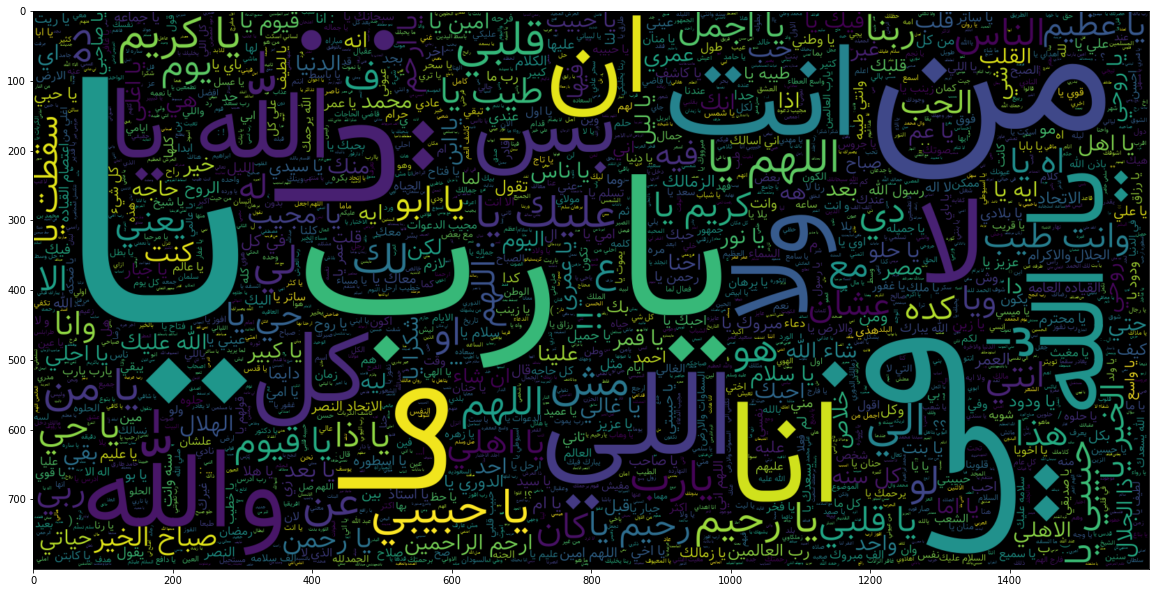

In [ ]:
#Not Offensive Words
from wordcloud_fa import WordCloudFa


plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'NOT_OFF'].tweets))
# wc = WordCloud(font_path='/content/drive/MyDrive/MasterThesis/NotoNaskhArabic-Regular.ttf',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'NOT_OFF'].tweets))

image = wc.to_image()
image.save('wordcloud.png')
plt.imshow(wc , interpolation = 'bilinear')

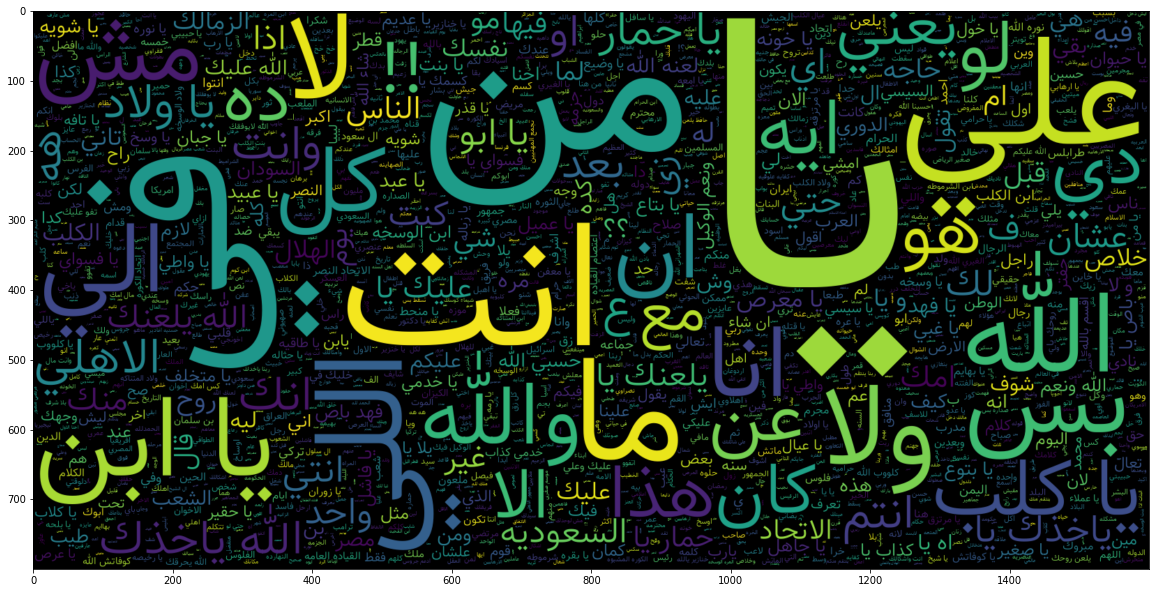

In [ ]:
plt.figure(figsize = (20,20)) 
wc=WordCloudFa(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.off == 'OFF'].tweets))
image = wc.to_image()
image.save('wordcloudoff.png')
plt.imshow(wc , interpolation = 'bilinear')

# Train and Test Split

In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300


In [ ]:
# train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
#                                          random_state=7) # Splits Dataset into Training and Testing set
# print("Train Data size:", len(train_data))
# print("Test Data size", len(test_data))
X_train, X_test, y_train, y_test = train_test_split(df.tweets,df.off, test_size = 0.2, random_state = 42, stratify=df.off)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 42, stratify=y_train)

print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))
print("Val Data size", len(X_val))

Train Data size: 7000
Test Data size 2000
Val Data size 1000


In [ ]:
# train_data.head(10)


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# tokenizer.fit_on_texts(X_test)

tokenizer.fit_on_texts(X_val)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)


Vocabulary Size : 35380


In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val),
                       maxlen = MAX_SEQUENCE_LENGTH)

X_test=pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=MAX_SEQUENCE_LENGTH)
print("Training X Shape:",X_train.shape)
print("Validation X Shape:",X_val.shape)
print("Testing X Shape:",X_test.shape)


Training X Shape: (7000, 300)
Validation X Shape: (1000, 300)
Testing X Shape: (2000, 300)


In [ ]:
# labels = train_data.off.unique().tolist()
# labels

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train.to_list())
# encoder.fit(y_val.to_list())
# encoder.fit(y_test.to_list())

y_train = encoder.transform(y_train.to_list())
y_val = encoder.transform(y_val.to_list())
Y_test = encoder.transform(y_test.to_list())

y_train = y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", Y_test.shape)
print("y_val shape:", y_val.shape)


y_train shape: (7000, 1)
y_test shape: (2000, 1)
y_val shape: (1000, 1)


In [ ]:
# Y_test

# Word embedding

In [ ]:
# !wget http://mazajak.inf.ed.ac.uk:8000/get_sg_250
# !wget https://www.dropbox.com/s/ce9phmmawoe1ure/Twt-CBOW.zip

In [ ]:
# !unzip Twt-CBOW.zip
# !gunzip -k cc.ar.300.vec.gz

In [ ]:
# !ls

In [ ]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 30


In [ ]:
# load the model
modelwv = gensim.models.Word2Vec.load('/content/drive/MyDrive/MasterThesis/Code/Offensive2020-SharedTask-Dataset/Word Embedding/Twt-CBOW/Twt-CBOW')

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in modelwv.wv.vocab:
      embedding_vector = modelwv[word]
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
print(embedding_matrix.shape)
# EMBEDDING_DIM=300


(35380, 300)


In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model Training - LSTM


In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from keras.layers import Dropout,Embedding,GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model


In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = Dropout(0.5)(embedding_sequences)

# Conv1D + global max pooling
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = Conv1D(64, 7, padding="valid", activation="relu", strides=3)(x)
x = Conv1D(32, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)
model = Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
# Adam(learning_rate=LR)
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
# ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
#                                      min_lr = 0.01,
#                                      monitor = 'val_loss',
#                                      verbose = 1)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
]

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/30
7/7 [==============================] - 2s 166ms/step - loss: 0.6789 - accuracy: 0.7941 - val_loss: 0.6314 - val_accuracy: 0.8010
Epoch 2/30
7/7 [==============================] - 1s 127ms/step - loss: 0.6110 - accuracy: 0.8016 - val_loss: 0.5593 - val_accuracy: 0.8010
Epoch 3/30
7/7 [==============================] - 1s 128ms/step - loss: 0.5237 - accuracy: 0.8004 - val_loss: 0.5115 - val_accuracy: 0.8010
Epoch 4/30
7/7 [==============================] - 1s 131ms/step - loss: 0.4975 - accuracy: 0.7933 - val_loss: 0.4996 - val_accuracy: 0.8010
Epoch 5/30
7/7 [==============================] - 1s 129ms/step - loss: 0.4746 - accuracy: 0.8008 - val_loss: 0.5125 - val_accuracy: 0.8010
Epoch 6/30
7/7 [==============================] - 1s 129ms/step - loss: 0.4497 - accuracy: 0.8000 - val_loss: 0.5343 - val_accuracy: 0.8010
Epoch 7/30
7/7 [==============================] - 1s 131ms/step - loss: 0.4107 - accuracy: 0.8147 - val_loss: 0.5674 - val_accuracy: 0.7960
Epoch 8/30
7/7 [====

In [ ]:
scores = model.evaluate(X_train,y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# print(y_train)

accuracy: 90.50%


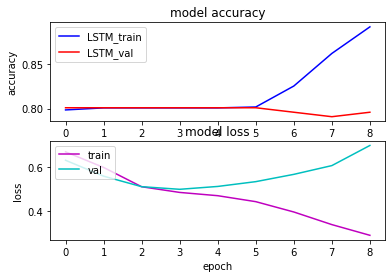

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
# evaluate the model
scorestest = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scorestest[1]*100))

accuracy: 79.25%


In [ ]:
model.evaluate(X_test, Y_test)

63/63 [==============================] - 0s 5ms/step - loss: 0.5687 - accuracy: 0.7925


[0.5686555504798889, 0.7925000190734863]

# Evaluate Validation set

In [ ]:
# make probability predictions with the model
predictionsVal = model.predict(X_val)
# round predictions 
roundedVal = [round(x[0]) for x in predictionsVal]
roundedVal[10:20]

cm=confusion_matrix(y_val,roundedVal)
print('confusion_matrix \n ',cm)

print(classification_report(list(y_val), roundedVal))


confusion_matrix 
  [[770  31]
 [173  26]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       801
           1       0.46      0.13      0.20       199

    accuracy                           0.80      1000
   macro avg       0.64      0.55      0.54      1000
weighted avg       0.74      0.80      0.75      1000



#Confusion Matrix¶


In [ ]:
# def decode_sentiment(score):
#     return "OFF" if (score>0.5).any() else "NOT_OFF"

# scores = model.predict(X_test, verbose=1, batch_size=100)

# # scores.astype(np.float32)
# # type(scores)
# y_pred_1d = np.array([decode_sentiment(score) for score in scores])
# print(y_pred_1d[:10])
# print(y_test[:10].to_list())

In [ ]:
# #Classification Scores

# print(classification_report(list(y_test), y_pred_1d))


In [ ]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import f1_score
# from sklearn.metrics import auc
# from matplotlib import pyplot
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# ns_probs = [0 for _ in range(len(Y_test))]
# # calculate roc curve
# fpr, tpr, thresholds = roc_curve(Y_test,ns_probs)

# ns_auc = roc_auc_score(Y_test,ns_probs)
# # lr_auc = roc_auc_score(testy, lr_probs)
# # summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))

# # predict probabilities
# # lr_probs = model.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# lr_probs = scores[:, 0]
# lr_auc = roc_auc_score(Y_test, lr_probs)
# lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

# pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

In [ ]:
# y_pred_1d = np.array([decode_sentiment(score) for score in scores])
# print(y_pred_1d[:10])
# print(y_test[:10].to_list())

In [ ]:
# import itertools
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# def plot_confusion_matrix(cm, classes,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """

#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=20)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, fontsize=13)
#     plt.yticks(tick_marks, classes, fontsize=13)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label', fontsize=17)
#     plt.xlabel('Predicted label', fontsize=17)


In [ ]:
# cnf_matrix = confusion_matrix(y_test.to_list(),y_pred_1d )
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
# plt.show()